Libraries

In [ ]:
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt

NOTE: Program is set up for AB_US_2023.csv. If using AB_Nashville.csv, rename the file read in below and delete 'city' from categorical_features. The Nashville results tend to be predicted more accurately using this model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AB_US_2023.csv to AB_US_2023.csv


Reading in the dataset

In [ ]:
df = pd.read_csv('AB_US_2023.csv', sep=None, engine = 'python')

Organizing the columns used in the prediction process and removing columns not utilized (Name, id, host, etc)

In [ ]:
#print(df.describe())
# Convert 'last_review' to datetime and fill NaNs for 'reviews_per_month'
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
# Reference date as the max last review date
reference_date = df['last_review'].max()

# Pull month and year from the last review
df['year'] = (df['last_review'].dt.year).fillna(0)
df['month'] = (df['last_review'].dt.month).fillna(0)

# Calculate days since last review and fill nan values
df['days_since_last_review'] = (reference_date - df['last_review']).dt.days
df['days_since_last_review'] = df['days_since_last_review'].fillna(df['days_since_last_review'].max() + 1)

# Drop columns that won't be used as features
drop_columns = ['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood_group', 'neighbourhood']
df = df.drop(columns=drop_columns)
#print(df.head())
#print(df.tail())

# Convert the target column (price) to log(price)
df['log_price'] = np.log1p(df['price'])

# Remove outliers in the 'log_price' column (log-prices that are beyond the 95th percentile)
upper_log_limit = df['log_price'].quantile(0.95)
df = df[df['log_price'] <= upper_log_limit]

# Prepare the numerical/categorical data for preprocessing
# REMOVE CITY HERE IF DATASET IS CHANGED TO AB_Nashville.csv
categorical_features = ['room_type', 'city']
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Removing the target variable from the numerical features list
numerical_features.remove('log_price')


Graph the numerical data from the dataset

In [ ]:
'''
import seaborn as sns

# Calculate correlation matrix
corr = df[numerical_features + ['log_price']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
'''

'\nimport seaborn as sns\n\n# Calculate correlation matrix\ncorr = df[numerical_features + [\'log_price\']].corr()\n\n# Plot heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(corr, annot=True, fmt=".2f", cmap=\'coolwarm\')\nplt.title(\'Correlation Matrix\')\nplt.show()\n'

Encode the column data and set up the ML pipeline

In [ ]:
# Encode the different types of column data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Set up ML pipeline based on ridge regression
model = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=1.0)
)

X = df.drop('log_price', axis=1)  # Features: all columns except price
y = df['log_price']               # Target Variable: price


Train/test/validate and model performance metrics

In [ ]:
# Train/test/validation sets based on an 80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the validation set and re-transform from log to original scale
y_val_pred = np.expm1(model.predict(X_val))
y_val_actual = np.expm1(y_val)

# Predict on the test set and re-transform from log to original scale
y_test_pred = np.expm1(model.predict(X_test))
y_test_actual = np.expm1(y_test)

# Calculate metrics for the validation set
val_mae = mean_absolute_error(y_val_actual, y_val_pred)
val_mse = mean_squared_error(y_val_actual, y_val_pred)
val_rmse = mean_squared_error(y_val_actual, y_val_pred, squared=False)
val_r2 = r2_score(y_val_actual, y_val_pred)

print(f"Validation Set Metrics:")
print(f"MAE: {val_mae}")
print(f"MSE: {val_mse}")
print(f"RMSE: {val_rmse}")
print(f"R^2: {val_r2}")


# Calculate metrics for the test set
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)
test_rmse = mean_squared_error(y_test_actual, y_test_pred, squared=False)
test_r2 = r2_score(y_test_actual, y_test_pred)

print(f"\nTest Set Metrics:")
print(f"MAE: {test_mae}")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_rmse}")
print(f"R^2: {test_r2}")

# Additional metrics
val_rmsle = mean_squared_log_error(y_val_actual, y_val_pred)
test_rmsle = mean_squared_log_error(y_test_actual, y_test_pred)

print(f"\nAdditional Metrics:")
print(f"Validation RMSLE: {val_rmsle}")
print(f"Test RMSLE: {test_rmsle}")

Validation Set Metrics:
MAE: 13.2941985218033
MSE: 1084.7055357867469
RMSE: 32.93486808515782
R^2: 0.9279158947170831

Test Set Metrics:
MAE: 13.055811799084434
MSE: 700.1884736489897
RMSE: 26.461074688095902
R^2: 0.9526948625470169

Additional Metrics:
Validation RMSLE: 0.01212555223445753
Test RMSLE: 0.012248341298920938


Graphing and analyzing the model's predictions


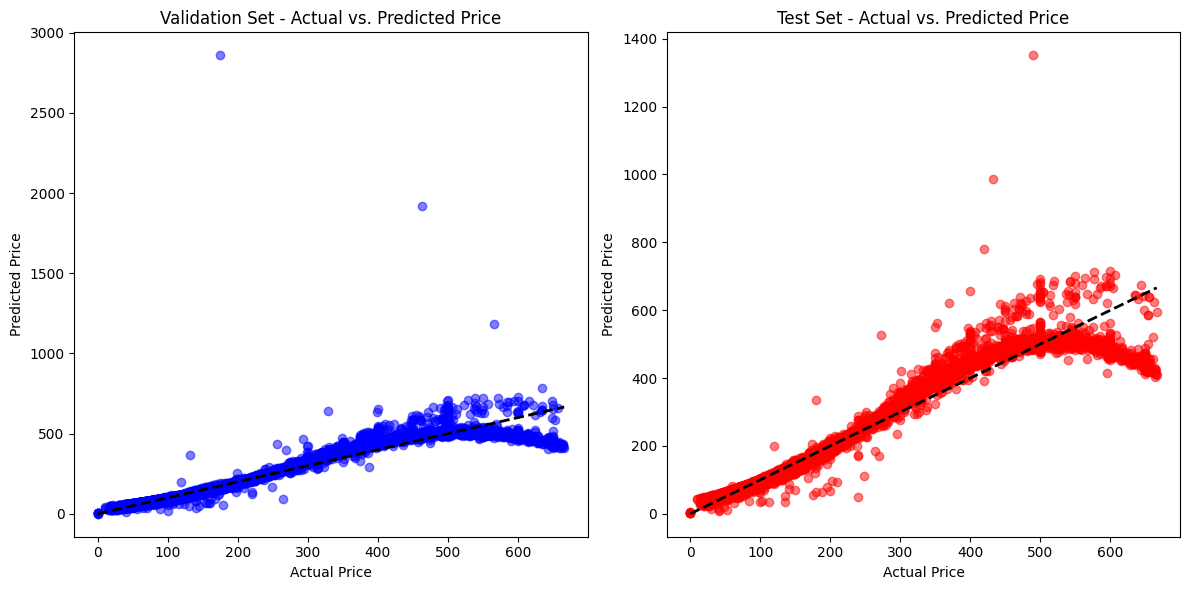

count    22055.000000
mean        -1.286787
std         32.910467
min      -2685.120584
25%         -6.518333
50%          2.157255
75%          7.052319
max        258.013760
Name: log_price, dtype: float64


'\n# Calculate residuals for the test set\nresiduals_test = y_test_actual - y_test_pred\n\nplt.hist(residuals_val, bins=30, alpha=0.5, color=\'blue\', label=\'Validation\')\nplt.hist(residuals_test, bins=30, alpha=0.5, color=\'red\', label=\'Test\')\nplt.title(\'Histogram of Residuals\')\nplt.xlabel(\'Residuals\')\nplt.ylabel(\'Frequency\')\nplt.legend()\nplt.show()\n\nimport scipy.stats as stats\n\nstats.probplot(residuals_val, dist="norm", plot=plt)\nplt.title(\'Q-Q Plot of Validation Residuals\')\nplt.show()\n\nstats.probplot(residuals_test, dist="norm", plot=plt)\nplt.title(\'Q-Q Plot of Test Residuals\')\nplt.show()\n\nplt.scatter(y_val_pred, residuals_val, alpha=0.5, color=\'blue\', label=\'Validation\')\nplt.scatter(y_test_pred, residuals_test, alpha=0.5, color=\'red\', label=\'Test\')\nplt.title(\'Residuals vs. Predicted Values\')\nplt.xlabel(\'Predicted Values\')\nplt.ylabel(\'Residuals\')\nplt.axhline(y=0, color=\'black\', linestyle=\'--\')\nplt.legend()\nplt.show()\n'

In [ ]:
# Plot for the Validation Set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(y_val_actual, y_val_pred, alpha=0.5, color='blue')
plt.plot([np.expm1(y).min(), np.expm1(y).max()], [np.expm1(y).min(), np.expm1(y).max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Validation Set - Actual vs. Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Plot for the Test Set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(y_test_actual, y_test_pred, alpha=0.5, color='red')
plt.plot([np.expm1(y).min(), np.expm1(y).max()], [np.expm1(y).min(), np.expm1(y).max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Test Set - Actual vs. Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()
#print(y_val_actual)

# Calculate residuals for the validation set
residuals_val = y_val_actual - y_val_pred
print(residuals_val.describe())
#print(residuals_val.head())
#print(residuals_val.tail())
'''
# Calculate residuals for the test set
residuals_test = y_test_actual - y_test_pred

plt.hist(residuals_val, bins=30, alpha=0.5, color='blue', label='Validation')
plt.hist(residuals_test, bins=30, alpha=0.5, color='red', label='Test')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

import scipy.stats as stats

stats.probplot(residuals_val, dist="norm", plot=plt)
plt.title('Q-Q Plot of Validation Residuals')
plt.show()

stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title('Q-Q Plot of Test Residuals')
plt.show()

plt.scatter(y_val_pred, residuals_val, alpha=0.5, color='blue', label='Validation')
plt.scatter(y_test_pred, residuals_test, alpha=0.5, color='red', label='Test')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()
'''




In [ ]:
'''
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
'''

'\nfrom sklearn.linear_model import Lasso\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.preprocessing import LabelEncoder\n'

In [ ]:
'''
label_encoder = LabelEncoder()
df['room_type_encoded'] = label_encoder.fit_transform(df['room_type'])
df['city_encoded'] = label_encoder.fit_transform(df['city'])
df['neighbourhood_encoded'] = label_encoder.fit_transform(df['neighbourhood'])  # Assuming the correct column name is 'neighborhood'
'''

"\nlabel_encoder = LabelEncoder()\ndf['room_type_encoded'] = label_encoder.fit_transform(df['room_type'])\ndf['city_encoded'] = label_encoder.fit_transform(df['city'])\ndf['neighbourhood_encoded'] = label_encoder.fit_transform(df['neighbourhood'])  # Assuming the correct column name is 'neighborhood'\n"

In [ ]:
'''
X = df[['room_type_encoded', 'city_encoded', 'neighbourhood_encoded']]
y = df['price']
'''

"\nX = df[['room_type_encoded', 'city_encoded', 'neighbourhood_encoded']]\ny = df['price']\n"

In [ ]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nlasso_model = Lasso(alpha=0.1)\nlasso_model.fit(X_train, y_train)\ny_pred = lasso_model.predict(X_test)\nmse = mean_squared_error(y_test, y_pred)\n'

In [ ]:
'''
print(f'Mean Squared Error: {mse}')
print(f'Coefficients: {lasso_model.coef_}')
'''

"\nprint(f'Mean Squared Error: {mse}')\nprint(f'Coefficients: {lasso_model.coef_}')\n"

In [ ]:
'''
r_squared = lasso_model.score(X_test, y_test)
print(f"R-squared: {r_squared}")
'''

'\nr_squared = lasso_model.score(X_test, y_test)\nprint(f"R-squared: {r_squared}")\n'

In [ ]:
#from sklearn.linear_model import ElasticNet

In [ ]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
y_pred = elastic_net_model.predict(X_test)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nelastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)\nelastic_net_model.fit(X_train, y_train)\ny_pred = elastic_net_model.predict(X_test)\n'

In [ ]:
'''
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
'''

"\nmse = mean_squared_error(y_test, y_pred)\nprint(f'Mean Squared Error: {mse}')\n"